<a href="https://colab.research.google.com/github/SaachiK08/PixelPairs_Augenblick-25/blob/main/PS_IPW_PixelPair_Augenblick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import CompareMeans

In [ ]:
# Load dataset
df = pd.read_csv("/content/ihdp_data.csv")

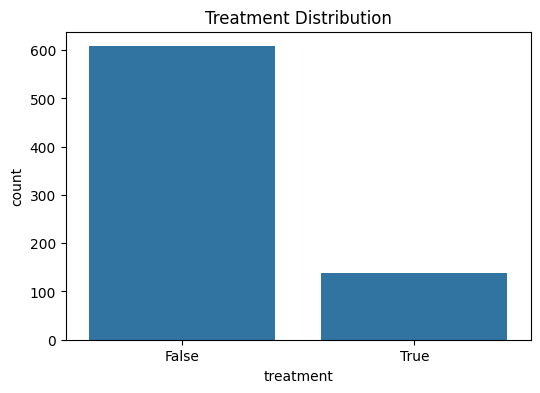

In [ ]:
# Step 1: Exploratory Data Analysis
plt.figure(figsize=(6,4))
sns.countplot(x='treatment', data=df)
plt.title("Treatment Distribution")
plt.show()

In [ ]:
# Step 2: Propensity Score Estimation
X = df.drop(columns=['treatment', 'y_factual', 'y_cfactual', 'mu0', 'mu1'])
y = df['treatment'].astype(int)

propensity_model = LogisticRegression()
propensity_model.fit(X, y)
df['propensity_score'] = propensity_model.predict_proba(X)[:,1]

In [ ]:
# Step 3: Inverse Probability Weighting (IPW)
df['weight'] = np.where(df['treatment'] == 1, 1/df['propensity_score'], 1/(1-df['propensity_score']))

In [ ]:
# Step 4: Estimating Treatment Effects
ate = np.mean(df[df['treatment']==1]['y_factual']) - np.mean(df[df['treatment']==0]['y_factual'])
print(f"Average Treatment Effect (ATE): {ate:.4f}")

Average Treatment Effect (ATE): 4.0211


In [ ]:
# Step 5: Causal Effect Estimation using ML
X_train, X_test, y_train, y_test = train_test_split(X, df['y_factual'], test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Model RMSE: {rmse:.4f}")

Model RMSE: 1.7910


In [ ]:
# Step 6: Hypothesis Testing
t_stat, p_value = ttest_ind(df[df['treatment'] == 1]['y_factual'], df[df['treatment'] == 0]['y_factual'])
print(f"T-Test p-value: {p_value:.4f}")

T-Test p-value: 0.0000


In [ ]:
# Step 7: Effect Size Calculation (Cohen's d)
mean_treated = np.mean(df[df['treatment'] == 1]['y_factual'])
mean_control = np.mean(df[df['treatment'] == 0]['y_factual'])
std_pooled = np.sqrt((np.var(df[df['treatment'] == 1]['y_factual']) + np.var(df[df['treatment'] == 0]['y_factual'])) / 2)
cohens_d = (mean_treated - mean_control) / std_pooled
print(f"Effect Size (Cohen's d): {cohens_d:.4f}")

Effect Size (Cohen's d): 2.9312


In [ ]:
# Step 8: Bootstrapped Confidence Intervals for ATE
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    boot_ate = []
    for _ in range(n_bootstrap):
        sample = data.sample(frac=1, replace=True)
        boot_ate.append(np.mean(sample[sample['treatment']==1]['y_factual']) - np.mean(sample[sample['treatment']==0]['y_factual']))
    lower = np.percentile(boot_ate, (100 - ci) / 2)
    upper = np.percentile(boot_ate, 100 - (100 - ci) / 2)
    return lower, upper

ci_lower, ci_upper = bootstrap_ci(df)
print(f"Bootstrapped 95% Confidence Interval for ATE: ({ci_lower:.4f}, {ci_upper:.4f})")

Bootstrapped 95% Confidence Interval for ATE: (3.8101, 4.2492)


In [ ]:
# Step 9: Doubly Robust Estimator using Regression Adjustment
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X, df['y_factual'])
df['y_pred'] = reg_model.predict(X)
dre_ate = np.mean(df[df['treatment'] == 1]['y_pred']) - np.mean(df[df['treatment'] == 0]['y_pred'])
print(f"Doubly Robust Estimated ATE: {dre_ate:.4f}")

Doubly Robust Estimated ATE: 0.5314
